# Specific Test III. Learning Mass of Dark Matter Halo 

The following notebook is my solution for Specific Test 3

In [12]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from torchvision import transforms
import seaborn as sns

# Visualizing and loading the dataset.

The dataset is first extracted and the displayed to understand what kind of input output pairs have been provided. I do not augument this dataset because inital test reveal that the MSE is quite low. However, to aid with generalisation as there was a some difference in training and test set results, I have used 4 transforms that will be selected randomly and applied to every image at every epoch. 

In [2]:
# Uncomment to load dataset 

# import os, sys, tarfile

# def extract(tar_url, extract_path='.'):
#     tar = tarfile.open(tar_url, 'r')
#     for item in tar:
#         tar.extract(item, extract_path)
#         if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
#             extract(item.name, "./" + item.name[:item.name.rfind('/')])

# extract("lens_data_alt.tgz")

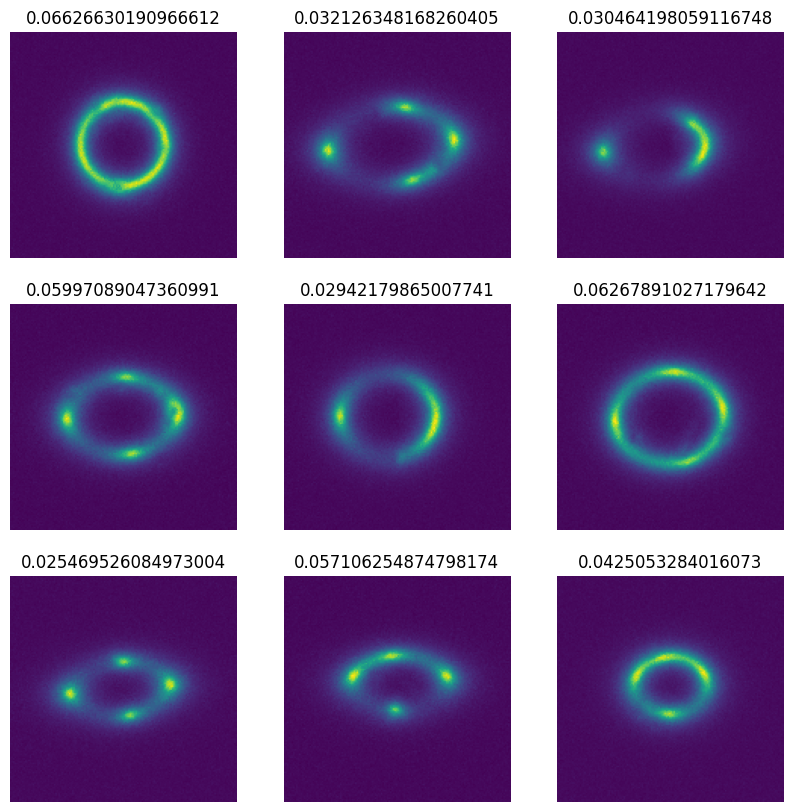

In [3]:
plt.figure(figsize = (10,10))
for i in range(1, 10):
    plt.subplot(3,3,i)
    plt.imshow(np.load("lens_data/"+os.listdir("lens_data")[i], allow_pickle=True)[0])
    plt.title(np.load("lens_data/"+os.listdir("lens_data")[i], allow_pickle=True)[1])
    plt.axis("off")

In [4]:

class LensDataset(Dataset):

    def __init__(self, root_dir, files):
        self.root_dir = root_dir
        self.files = files
        # Transforms

        self.transform_to_apply = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.RandomRotation([-90, +90]),
        ]
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.root_dir+"/"+self.files[idx], allow_pickle=True)
        
        return self.transform_to_apply[np.random.randint(4)](torch.Tensor(data[0]).reshape(1, *data[0].shape)), torch.Tensor([data[1]])

In [5]:
class LensDataModule(pl.LightningDataModule):
    def __init__(
        self,
        root_dir,
        batch_size = 16,
        dataloader_num_workers = 1,
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataloader_num_workers = dataloader_num_workers
        self.root_dir = root_dir

        files = os.listdir(self.root_dir)
        train_images, test_images = train_test_split(files, test_size = 0.1, random_state = 420)
        self.train_images = train_images
        self.test_images = test_images


    def train_dataloader(self):
        
        return DataLoader(
            LensDataset(self.root_dir, self.train_images),
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.dataloader_num_workers
        )
    
    def test_dataloader(self):
        return DataLoader(
            LensDataset(self.root_dir, self.test_images),
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers=self.dataloader_num_workers
        )


# Model creation and training

I am using a modified Resnet architecture with a custom input convolution and regression MLP head. I am training the model on the SmoothL1Loss and MSELoss to see which performs better. 

In [6]:
class LensNet(pl.LightningModule):

    def __init__(self):
        super(LensNet, self).__init__()
        self.criterion = nn.MSELoss() #Change to MSELoss() or L1Loss() as required
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.LazyLinear(1)
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0008)
        return [optimizer]
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        
    def predict_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        return pred, y
        

In [7]:
data_module = LensDataModule("lens_data")
model = LensNet()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [8]:
# Uncomment to load model from storage
# model.load_state_dict(torch.load("regression.model"))

<All keys matched successfully>

In [10]:
trainer = pl.Trainer(max_epochs = 200, accelerator = "gpu", enable_progress_bar = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:411: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | model     | ResNet  | 11.2 M
--------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.681    Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


# Test Metrics (MSE)

In [11]:
preds = trainer.predict(model, data_module.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [13]:
pred = np.zeros((250*16, ))
true = np.zeros((250*16, ))

for i, value in enumerate(preds):
    pred[i*16:(i+1)*16] = value[0].reshape(-1)
    true[i*16:(i+1)*16] = value[1].reshape(-1)

In [14]:
mean_squared_error(pred, true)

5.345248798810308e-05

In [15]:
mean_absolute_error(pred, true)

0.005660139752144459

In [16]:
np.sqrt(mean_squared_error(pred, true))

0.007311120843489258

In [17]:
r2_score(pred, true)

0.6627936493337598

In [18]:
mean_absolute_percentage_error(pred, true)

0.14917687766985255

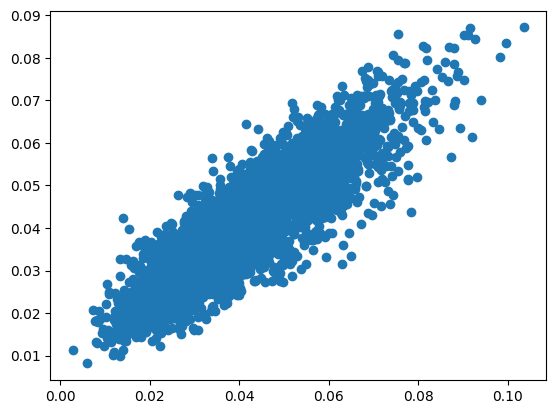

In [19]:
plt.scatter(true, pred)

# Train metrics (MSE)

In [20]:
preds = trainer.predict(model, data_module.train_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [21]:
pred = np.zeros((len(preds)*16, ))
true = np.zeros((len(preds)*16, ))

for i, value in enumerate(preds):
    pred[i*16:(i+1)*16] = value[0].reshape(-1)
    true[i*16:(i+1)*16] = value[1].reshape(-1)

# Train MSE

In [22]:
mean_squared_error(pred, true)

2.2421325389070734e-05

In [23]:
mean_absolute_error(pred, true)

0.0035498909324669513

In [24]:
np.sqrt(mean_squared_error(pred, true))

0.004735116195941841

In [25]:
r2_score(pred, true)

0.8765427718833925

In [26]:
mean_absolute_percentage_error(pred, true)

0.09458768051009679

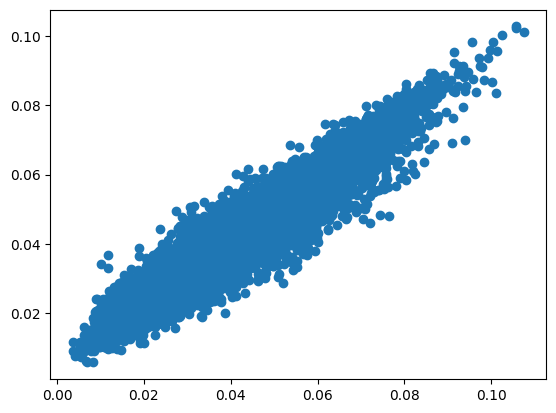

In [27]:
plt.scatter(true, pred)

In [28]:
torch.save(model.state_dict(), "regression_mse.model")